# Лабораторная работа 5: Обучение и тестирование модели

**Import Libraries:**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import random
import matplotlib.pyplot as plt

**Простая Сверточная Нейронная Сеть (CNN)**

Код определяет простую модель сверточной нейронной сети (CNN) с именем SimpleCNN, предназначенную для задач классификации изображений.  
 Эта архитектура состоит из двух сверточных слоев ( conv1и conv2), за каждым из которых следует активация выпрямленной линейной единицы (ReLU)   
 и уровни максимального пула. Полносвязный слой ( fc1) в конце дает окончательный результат для классификации.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 2) -> None:
        """
        Simple Convolutional Neural Network (CNN) model.

        Parameters:
        - num_classes: Number of classes for classification.
        """
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 32, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x: Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

**Набор данных для классификации изображений**

В данном коде определен класс пользовательского набора данных, CustomDataset, специально разработанный для задач классификации изображений.  
Этот класс носит наследственный характер от класса Dataset библиотеки PyTorch, что обеспечивает удобное взаимодействие с загрузчиками данных.

Структура Набора Данных:  
- Каждое изображение загружается с использованием библиотеки PIL и преобразуется в формат RGB.  
- Если указаны преобразования, они применяются к изображению.  
- Метки получаются из предоставленного списка, и, если предоставлено отображение меток, строковые метки преобразуются в числовые индексы.

In [3]:
class CustomDataset(Dataset):
    def __init__(
        self,
        img_paths: list,
        labels: list,
        transform: transforms.Compose = None,
        label_mapping: dict = None,
    ) -> None:
        """
        Custom dataset class for image classification.

        Parameters:
        - img_paths: List of image file paths.
        - labels: List of corresponding labels.
        - transform: Image transformations.
        - label_mapping: Mapping of label strings to numerical indices.
        """
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self) -> int:
        """
        Get the length of the dataset.

        Returns:
        - int: Length of the dataset.
        """
        return len(self.img_paths)

    def __getitem__(self, idx: int) -> tuple:
        """
        Get item from the dataset.

        Parameters:
        - idx: Index of the item.

        Returns:
        - tuple: (image, label)
        """
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label_str = self.labels[idx]
        label = self.label_mapping[label_str] if self.label_mapping else int(
            label_str)

        return img, torch.tensor(label)

**Разделение Датасета**

Данный код реализует функцию split_dataset, предназначенную для разделения датасета на обучающую, валидационную и тестовую выборки.

Характеристики:  
- Выводится информация о размерах общего датасета, а также размерах обучающей, валидационной и тестовой выборок.  
- Данные случайным образом перемешиваются для обеспечения статистической независимости.  
- Выбрасывается исключение, если недостаточно образцов для обучения.

In [4]:
def split_dataset(
    img_list: list,
    labels: list,
    train_size: float = 0.8,
    val_size: float = 0.1,
    test_size: float = 0.1,
) -> tuple:
    """
    Split the dataset into training, validation, and test sets.

    Parameters:
    - img_list: List of image file paths.
    - labels: List of corresponding labels.
    - train_size: Percentage of data for training.
    - val_size: Percentage of data for validation.
    - test_size: Percentage of data for testing.

    Returns:
    - tuple: img_train, labels_train, img_val, labels_val, img_test, labels_test
    """
    total_size = len(img_list)

    print(f"Total dataset size: {total_size}")

    train_size = int(total_size * train_size)
    val_size = int(total_size * val_size)
    test_size = int(total_size * test_size)

    print(f"Training dataset size: {train_size}")
    print(f"Validation dataset size: {val_size}")
    print(f"Test dataset size: {test_size}")

    if train_size <= 0:
        raise ValueError("Not enough samples for training.")

    combined = list(zip(img_list, labels))
    random.seed(42)
    random.shuffle(combined)
    img_list[:], labels[:] = zip(*combined)

    img_val, labels_val = img_list[:val_size], labels[:val_size]
    img_test, labels_test = img_list[val_size:val_size +
                                     test_size], labels[val_size:val_size + test_size]
    img_train, labels_train = img_list[val_size + test_size:val_size + test_size +
                                       train_size], labels[val_size + test_size:val_size + test_size + train_size]

    return img_train, labels_train, img_val, labels_val, img_test, labels_test



**Загрузка Датасета**

Данный код реализует функцию load_dataset, предназначенную для загрузки датасета из CSV-файла и его последующего разделения на обучающую, валидационную и тестовую выборки.

Особенности:  
- Данные считываются из CSV-файла, представленного в виде датафрейма Pandas.  
- Датасет случайным образом перемешивается для улучшения статистической независимости.  
- Выводится информация о размерах оригинального датасета, а также размерах обучающей, валидационной и тестовой выборок.

Обработка Исключений:  
- Обработка исключений, таких как отсутствие файла, пустой файл, ошибки значения и неожиданная ошибка.


In [5]:
def load_dataset(
    csv_path: str,
    train_size: float = 0.8,
    val_size: float = 0.1,
    test_size: float = 0.1,
) -> tuple:
    """
    Load dataset from a CSV file and split it into training, validation, and test sets.

    Parameters:
    - csv_path: Path to the CSV file containing image annotations.
    - train_size: Percentage of data for training.
    - val_size: Percentage of data for validation.
    - test_size: Percentage of data for testing.

    Returns:
    - tuple: img_train, labels_train, img_val, labels_val, img_test, labels_test
    """
    try:
        dframe = pd.read_csv(
            csv_path, delimiter=",", names=["Absolute path", "Relative path", "Class"]
        )
        img_list = dframe["Absolute path"].tolist()
        labels = dframe["Class"].tolist()

        if not img_list or not labels:
            raise ValueError("Empty dataset: No images or labels found.")

        img_list, labels = list(img_list), list(labels)

        combined = list(zip(img_list, labels))
        random.seed(42)
        random.shuffle(combined)
        img_list[:], labels[:] = zip(*combined)

        img_train, labels_train, img_val, labels_val, img_test, labels_test = split_dataset(
            img_list, labels, train_size=train_size, val_size=val_size, test_size=test_size
        )

        return img_train, labels_train, img_val, labels_val, img_test, labels_test
    except FileNotFoundError:
        print(f"Error: File not found at path '{csv_path}'")
        return [], [], [], [], [], []
    except pd.errors.EmptyDataError:
        print(f"Error: Empty file at path '{csv_path}'")
        return [], [], [], [], [], []
    except ValueError as ve:
        print(f"ValueError: {ve}")
        return [], [], [], [], [], []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return [], [], [], [], [], []

**Расчет Точности (Accuracy)**

Данный код содержит функцию calculate_accuracy, которая предназначена для вычисления точности (accuracy) модели на основе предсказанных и истинных меток.

Описание:  
- Код использует генератор списка для проверки, сколько из предсказанных меток совпадают с истинными.  
- Расчет производится путем деления числа правильных предсказаний на общее количество предсказаний.

Возвращаемое Значение:  
- Вещественное число, представляющее процент точности.

In [6]:
def calculate_accuracy(predictions: list, true_labels: list) -> float:
    """
    Calculate accuracy given predicted and true labels.

    Parameters:
    - predictions: Predicted labels.
    - true_labels: True labels.

    Returns:
    - float: Accuracy.
    """
    correct = sum(p == t for p, t in zip(predictions, true_labels))
    total = len(predictions)
    return correct / total

**Визуализация Результатов Обучения**

Данный код определяет функцию plot_training_results, которая предназначена для построения графиков результатов обучения и валидации.

Параметры:  
- train_losses: Список значений функции потерь на обучающей выборке.  
- val_losses: Список значений функции потерь на валидационной выборке.  
- val_accuracies: Список значений точности на валидационной выборке.  
- learning_rate: Скорость обучения (learning rate).  
- batch_size: Размер пакета (batch size).

Детали Графика:

Левый График (subplot 1, 2, 1):  
- Линии для функции потерь на обучающей (Training Loss) и валидационной (Validation Loss) выборках.  
- Точки (marker='o') обозначают значения на каждой эпохе.  
- Заголовок графика: "Training and Validation Loss".  
- Ось X: Эпохи.  
- Ось Y: Значения функции потерь.  
- Легенда для обозначения линий.

Правый График (subplot 1, 2, 2):  
- Линия для точности на валидационной выборке (Validation Accuracy).  
- Точки (marker='o') обозначают значения на каждой эпохе.  
- Заголовок графика: "Validation Accuracy".  
- Ось X: Эпохи.  
- Ось Y: Значения точности.  

- Сверху: Общий заголовок, включающий значения скорости обучения и размера пакета.
Легенда для обозначения линии.

In [7]:
def plot_training_results(
    train_losses: list,
    val_losses: list,
    val_accuracies: list,
    learning_rate: float,
    batch_size: int,
) -> None:
    """
    Plot training and validation results.

    Parameters:
    - train_losses: Training losses.
    - val_losses: Validation losses.
    - val_accuracies: Validation accuracies.
    - learning_rate: Learning rate.
    - batch_size: Batch size.
    """
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy',
             marker='o', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.suptitle(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}')
    plt.legend()

    plt.tight_layout()
    plt.show()

**Функция Обучения Модели**

Эта функция (train_model) выполняет обучение нейронной сети на заданных наборах данных и выводит информацию о процессе обучения, включая потери на обучающем и валидационном наборах, а также точность на валидационном наборе.

Параметры:
- model: Нейронная сеть для обучения.
- train_loader: Загрузчик данных для обучающего набора.
- val_loader: Загрузчик данных для валидационного набора.
- device: Устройство для обучения (например, "cuda" или "cpu").
- num_epochs: Количество эпох обучения.
- learning_rate: Темп обучения.

Детали:
- Модель и данные перемещаются на указанное устройство.
- Используется кросс-энтропийная функция потерь и оптимизатор Adam.
- В каждой эпохе:
    - Модель переводится в режим обучения (model.train()).
    - Обучающий набор прогоняется через модель, потери вычисляются и обновляются веса.
    - Записываются потери на обучающем наборе.
    - Модель переводится в режим оценки (model.eval()).
    - Валидационный набор используется для оценки модели, вычисляются потери и точность.
    - Записываются потери и точность на валидационном наборе.

Вывод:
- В каждой эпохе выводится информация о потерях и точности на валидационном наборе.

Возвращаемое значение:
- Возвращается кортеж, содержащий списки обучающих потерь, валидационных потерь и валидационных точностей.


In [8]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    num_epochs: int = 10,
    learning_rate: float = 0.001,
) -> tuple:
    """
    Train the given model using the specified data loaders.

    Parameters:
    - model: Neural network model.
    - train_loader: Training data loader.
    - val_loader: Validation data loader.
    - device: Device for training (e.g., "cuda" or "cpu").
    - num_epochs: Number of training epochs.
    - learning_rate: Learning rate.

    Returns:
    - tuple: train_losses, val_losses, val_accuracies
    """
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        for images, labels in train_loader:
            images = torch.stack([img.to(device) for img in images])
            labels = torch.as_tensor(
                labels, dtype=torch.long).clone().detach().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            predictions = []
            true_labels = []
            for images, labels in val_loader:
                images = torch.stack([img.to(device) for img in images])
                labels = torch.as_tensor(
                    labels, dtype=torch.long).clone().detach().to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            accuracy = calculate_accuracy(predictions, true_labels)

            print(
                f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

            val_losses.append(val_loss)
            val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

**Оценка Модели на Тестовом Наборе**

Этот код определяет функцию evaluate_model, которая оценивает производительность модели на тестовом наборе данных и выводит точность.

Параметры:
- model: Нейронная сеть для оценки.
- test_loader: Загрузчик данных для тестового набора.
- device: Устройство для оценки (например, "cuda" или "cpu").

Детали:
- Модель отправляется на указанное устройство (model.to(device)).
- Модель переводится в режим оценки (model.eval()).
- Без вычисления градиентов с использованием torch.no_grad(), модель оценивает тестовый набор данных.
- Предсказания и истинные метки собираются в списки для последующего вычисления точности с использованием функции calculate_accuracy.

Вывод:
- Выводится точность модели на тестовом наборе данных.


In [9]:
def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> None:
    """
    Evaluate the model on the test set and print the accuracy.

    Parameters:
    - model: Neural network model.
    - test_loader: Test data loader.
    - device: Device for evaluation (e.g., "cuda" or "cpu").
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        test_predictions = []
        test_true_labels = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    test_accuracy = calculate_accuracy(test_predictions, test_true_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")


**Основная Функция: Обучение и Оценка Модели**

Эта основная функция (main) выполняет обучение и оценку модели для различных комбинаций темпа обучения и размера пакета.

Параметры:  
- csv_path: Путь к файлу CSV с аннотациями изображений.  
- num_epochs: Количество эпох обучения.

Детали:  
- Определяется устройство для обучения (cuda если доступно, иначе cpu).  
- Загружаются данные и разделяются на обучающий, валидационный и тестовый наборы.  
- Создается отображение меток для преобразования строковых меток в числовые индексы.  
- Определяются темпы обучения и размеры пакетов для экспериментов.  
- Для каждой комбинации темпа обучения и размера пакета:  
    - Создается набор данных и загрузчики данных для обучения, валидации и тестирования.  
    - Инициализируется модель CNN (SimpleCNN) с количеством классов, соответствующим количеству уникальных меток.  
    - Модель обучается с использованием функции train_model.  
    - Результаты обучения визуализируются с использованием функции plot_training_results.  
    - Модель оценивается на тестовом наборе данных с использованием функции evaluate_model.

Вывод:  
- Для каждой комбинации темпа обучения и размера пакета выводится информация о ходе обучения и результаты оценки на тестовом наборе данных.

In [10]:
def main(csv_path: str, num_epochs: int = 10) -> nn.Module:
    """
    Main function for training and evaluating the model.

    Parameters:
    - csv_path: Path to the CSV file containing image annotations.
    - num_epochs: Number of training epochs.

    Returns:
    - nn.Module: Trained neural network model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    img_train, labels_train, img_val, labels_val, img_test, labels_test = load_dataset(
        csv_path)

    unique_labels = set(labels_train + labels_val + labels_test)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]

    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            print(
                f"\nExperiment: Learning Rate = {learning_rate}, Batch Size = {batch_size}")

            transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
            ])

            train_dataset = CustomDataset(
                img_train, labels_train, transform, label_mapping)
            val_dataset = CustomDataset(
                img_val, labels_val, transform, label_mapping)
            test_dataset = CustomDataset(
                img_test, labels_test, transform, label_mapping)

            train_loader = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
            val_loader = DataLoader(
                val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
            test_loader = DataLoader(
                test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

            model = SimpleCNN(num_classes=len(unique_labels)).to(device)

            train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, device,
                                                                   num_epochs=num_epochs, learning_rate=learning_rate)

            plot_training_results(train_losses, val_losses,
                                  val_accuracies, learning_rate, batch_size)

            evaluate_model(model, test_loader, device)
    return model

**Основной блок выполнения: Обучение и Оценка Модели**

В этом блоке кода осуществляется обучение нейронной сети и оценка ее производительности.

Шаги:
1. Определение устройства для обучения (GPU или CPU).
2. Загрузка и подготовка наборов данных для обучения, валидации и тестирования.
3. Создание уникального отображения меток классов.
4. Обучение модели с использованием функции main, устанавливая количество эпох в 10.
5. Сохранение обученной модели в файл simple_cnn_model.pth.
6. Загрузка сохраненной модели для дальнейшей оценки.
7. Подготовка и отправка изображения для предсказания класса с использованием новой модели.
8. Вывод предсказанного индекса класса для примера изображения.
9. Отображение примера изображения.

Using device: cuda
Total dataset size: 2000
Training dataset size: 1600
Validation dataset size: 200
Test dataset size: 200
Using device: cuda
Total dataset size: 2000
Training dataset size: 1600
Validation dataset size: 200
Test dataset size: 200

Experiment: Learning Rate = 0.001, Batch Size = 16


Epoch 1/10, Validation Loss: 0.1051, Accuracy: 0.9550
Epoch 2/10, Validation Loss: 0.1201, Accuracy: 0.9750
Epoch 3/10, Validation Loss: 0.0304, Accuracy: 1.0000
Epoch 4/10, Validation Loss: 0.0154, Accuracy: 1.0000
Epoch 5/10, Validation Loss: 0.0087, Accuracy: 1.0000
Epoch 6/10, Validation Loss: 0.0301, Accuracy: 0.9900
Epoch 7/10, Validation Loss: 0.0172, Accuracy: 1.0000
Epoch 8/10, Validation Loss: 0.0066, Accuracy: 1.0000
Epoch 9/10, Validation Loss: 0.0201, Accuracy: 0.9950
Epoch 10/10, Validation Loss: 0.0065, Accuracy: 1.0000


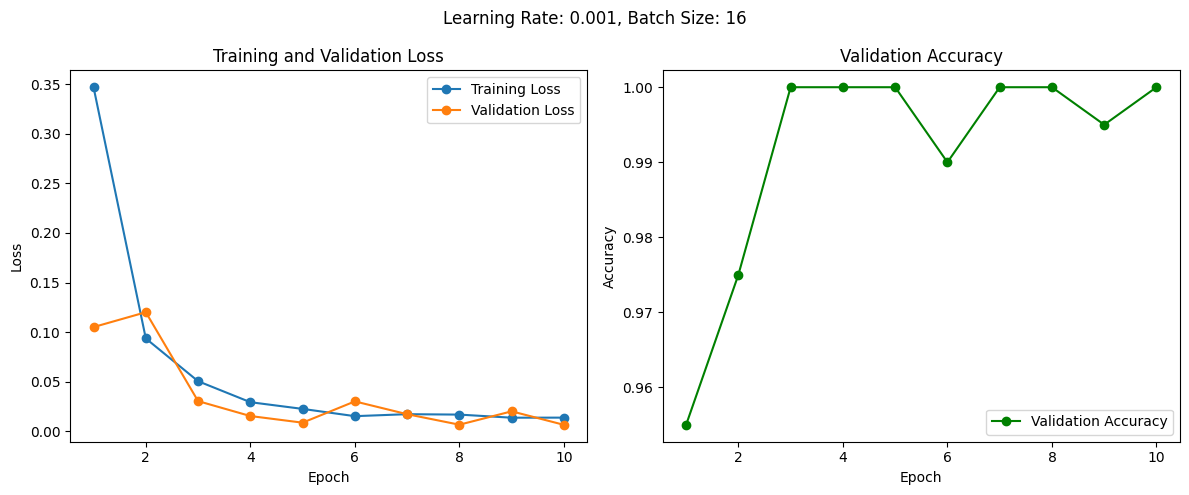

Test Accuracy: 0.9950

Experiment: Learning Rate = 0.001, Batch Size = 32
Epoch 1/10, Validation Loss: 0.1675, Accuracy: 0.9450
Epoch 2/10, Validation Loss: 0.0673, Accuracy: 0.9750
Epoch 3/10, Validation Loss: 0.0485, Accuracy: 0.9800
Epoch 4/10, Validation Loss: 0.0794, Accuracy: 0.9850
Epoch 5/10, Validation Loss: 0.0365, Accuracy: 0.9900
Epoch 6/10, Validation Loss: 0.0181, Accuracy: 1.0000
Epoch 7/10, Validation Loss: 0.0164, Accuracy: 0.9950
Epoch 8/10, Validation Loss: 0.0161, Accuracy: 1.0000
Epoch 9/10, Validation Loss: 0.0055, Accuracy: 1.0000
Epoch 10/10, Validation Loss: 0.0042, Accuracy: 1.0000


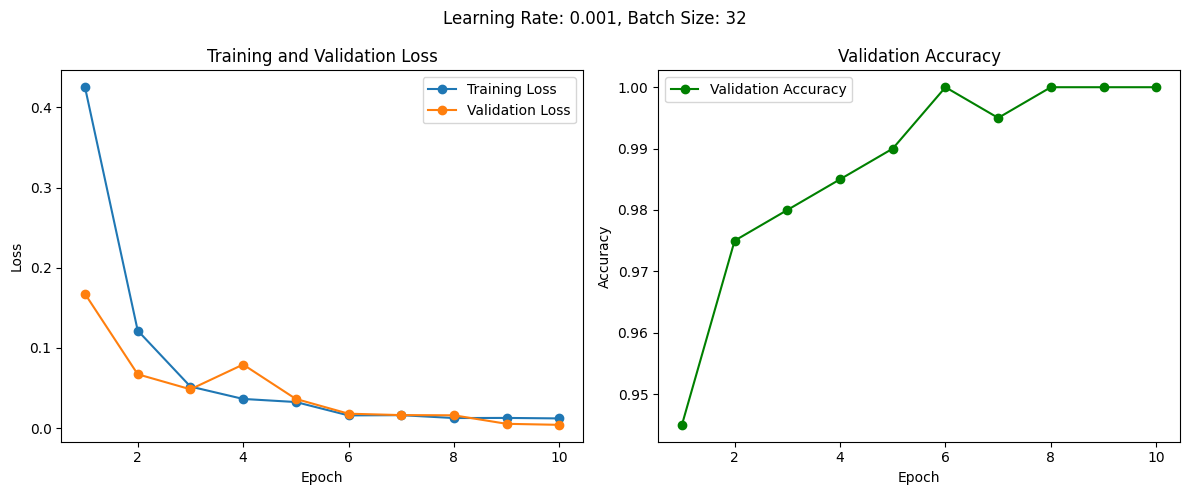

Test Accuracy: 0.9950

Experiment: Learning Rate = 0.001, Batch Size = 64
Epoch 1/10, Validation Loss: 0.1903, Accuracy: 0.9000
Epoch 2/10, Validation Loss: 0.1044, Accuracy: 0.9700
Epoch 3/10, Validation Loss: 0.0602, Accuracy: 0.9900
Epoch 4/10, Validation Loss: 0.0340, Accuracy: 0.9850
Epoch 5/10, Validation Loss: 0.0554, Accuracy: 0.9900
Epoch 6/10, Validation Loss: 0.0221, Accuracy: 0.9850
Epoch 7/10, Validation Loss: 0.0229, Accuracy: 1.0000
Epoch 8/10, Validation Loss: 0.0141, Accuracy: 1.0000
Epoch 9/10, Validation Loss: 0.0213, Accuracy: 0.9950
Epoch 10/10, Validation Loss: 0.0125, Accuracy: 1.0000


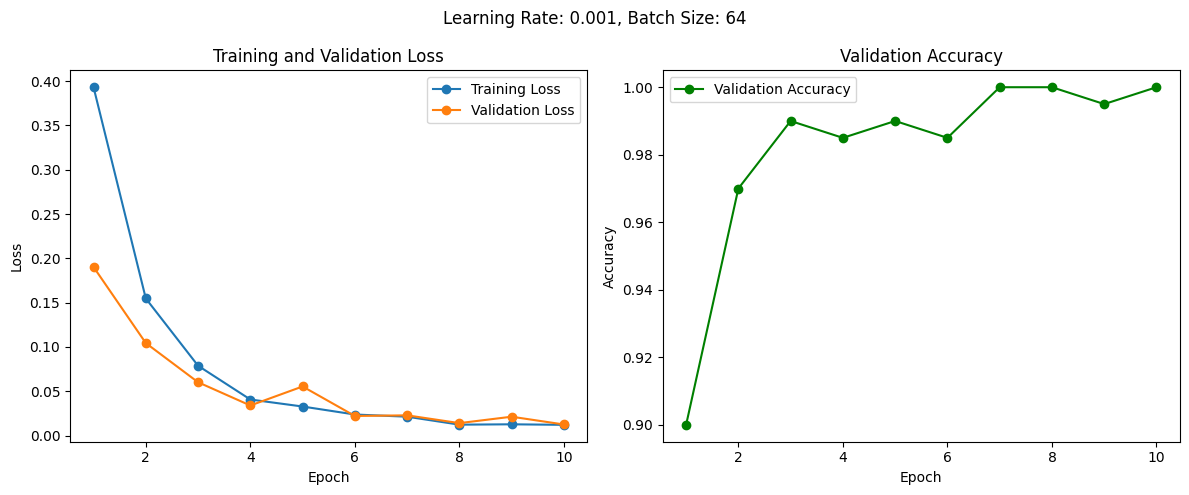

Test Accuracy: 0.9950

Experiment: Learning Rate = 0.01, Batch Size = 16
Epoch 1/10, Validation Loss: 0.1428, Accuracy: 0.9600
Epoch 2/10, Validation Loss: 0.1174, Accuracy: 0.9700
Epoch 3/10, Validation Loss: 0.1239, Accuracy: 0.9800
Epoch 4/10, Validation Loss: 0.1727, Accuracy: 0.9800
Epoch 5/10, Validation Loss: 0.0927, Accuracy: 0.9900
Epoch 6/10, Validation Loss: 0.1211, Accuracy: 0.9900
Epoch 7/10, Validation Loss: 0.1262, Accuracy: 0.9850
Epoch 8/10, Validation Loss: 0.1314, Accuracy: 0.9850
Epoch 9/10, Validation Loss: 0.1379, Accuracy: 0.9850
Epoch 10/10, Validation Loss: 0.0687, Accuracy: 0.9950


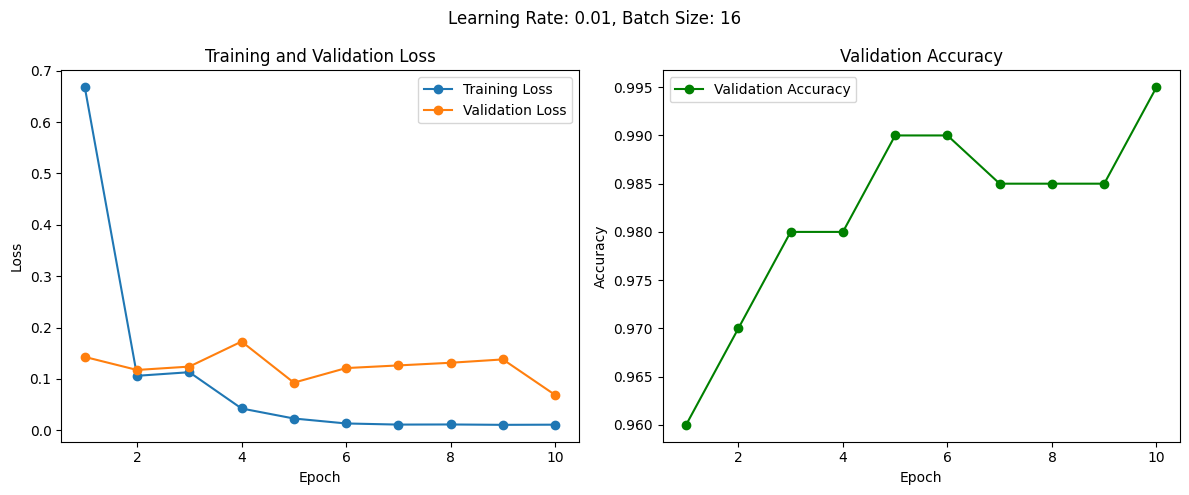

Test Accuracy: 0.9900

Experiment: Learning Rate = 0.01, Batch Size = 32
Epoch 1/10, Validation Loss: 0.3891, Accuracy: 0.7900
Epoch 2/10, Validation Loss: 0.1564, Accuracy: 0.9650
Epoch 3/10, Validation Loss: 0.1428, Accuracy: 0.9650
Epoch 4/10, Validation Loss: 0.0889, Accuracy: 0.9750
Epoch 5/10, Validation Loss: 0.0657, Accuracy: 0.9750
Epoch 6/10, Validation Loss: 0.0842, Accuracy: 0.9700
Epoch 7/10, Validation Loss: 0.0787, Accuracy: 0.9700
Epoch 8/10, Validation Loss: 0.0551, Accuracy: 0.9850
Epoch 9/10, Validation Loss: 0.0857, Accuracy: 0.9600
Epoch 10/10, Validation Loss: 0.0787, Accuracy: 0.9800


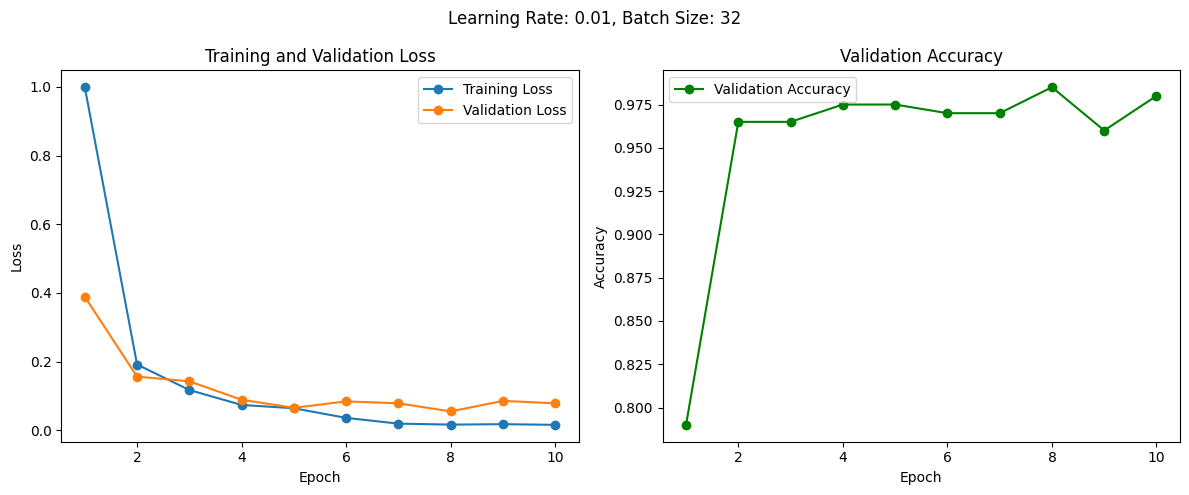

Test Accuracy: 0.9850

Experiment: Learning Rate = 0.01, Batch Size = 64
Epoch 1/10, Validation Loss: 0.7017, Accuracy: 0.4400
Epoch 2/10, Validation Loss: 0.6982, Accuracy: 0.4400
Epoch 3/10, Validation Loss: 0.6968, Accuracy: 0.4400
Epoch 4/10, Validation Loss: 0.6974, Accuracy: 0.4400
Epoch 5/10, Validation Loss: 0.6966, Accuracy: 0.4400
Epoch 6/10, Validation Loss: 0.6966, Accuracy: 0.4400
Epoch 7/10, Validation Loss: 0.6965, Accuracy: 0.4400
Epoch 8/10, Validation Loss: 0.6964, Accuracy: 0.4400
Epoch 9/10, Validation Loss: 0.6988, Accuracy: 0.4400
Epoch 10/10, Validation Loss: 0.6951, Accuracy: 0.4400


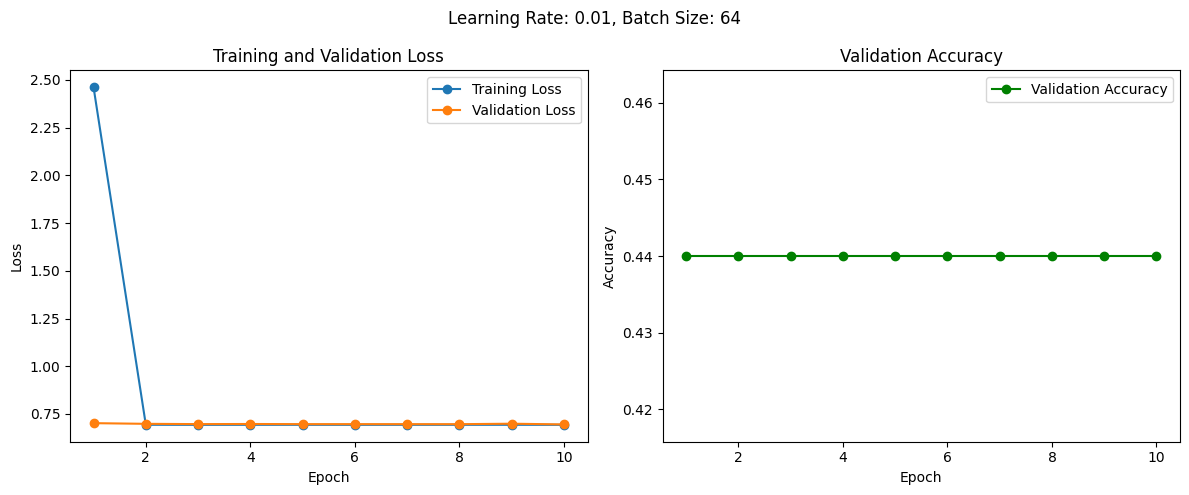

Test Accuracy: 0.4700

Experiment: Learning Rate = 0.1, Batch Size = 16
Epoch 1/10, Validation Loss: 0.6867, Accuracy: 0.5600
Epoch 2/10, Validation Loss: 0.6953, Accuracy: 0.4400
Epoch 3/10, Validation Loss: 0.7491, Accuracy: 0.4400
Epoch 4/10, Validation Loss: 0.6929, Accuracy: 0.5600
Epoch 5/10, Validation Loss: 0.7032, Accuracy: 0.4400
Epoch 6/10, Validation Loss: 0.7399, Accuracy: 0.4400
Epoch 7/10, Validation Loss: 0.7363, Accuracy: 0.4400
Epoch 8/10, Validation Loss: 0.6952, Accuracy: 0.4400
Epoch 9/10, Validation Loss: 0.6882, Accuracy: 0.5600
Epoch 10/10, Validation Loss: 0.7047, Accuracy: 0.4400


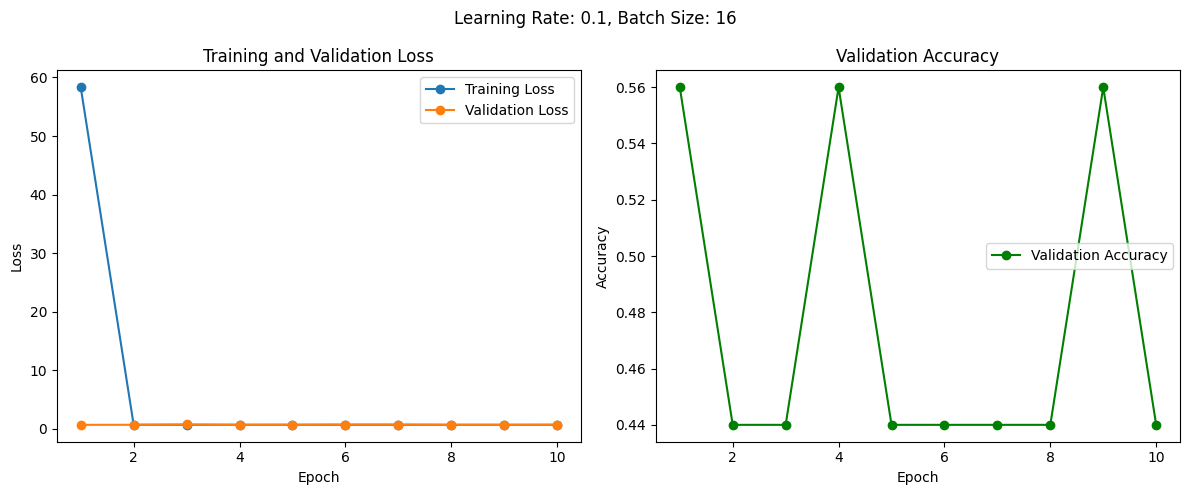

Test Accuracy: 0.4700

Experiment: Learning Rate = 0.1, Batch Size = 32
Epoch 1/10, Validation Loss: 0.6980, Accuracy: 0.4400
Epoch 2/10, Validation Loss: 0.7025, Accuracy: 0.4400
Epoch 3/10, Validation Loss: 0.6874, Accuracy: 0.5600
Epoch 4/10, Validation Loss: 0.6892, Accuracy: 0.5600
Epoch 5/10, Validation Loss: 0.6939, Accuracy: 0.4400
Epoch 6/10, Validation Loss: 0.6912, Accuracy: 0.5600
Epoch 7/10, Validation Loss: 0.6951, Accuracy: 0.4400
Epoch 8/10, Validation Loss: 0.7135, Accuracy: 0.4400
Epoch 9/10, Validation Loss: 0.6906, Accuracy: 0.5600
Epoch 10/10, Validation Loss: 0.7166, Accuracy: 0.4400


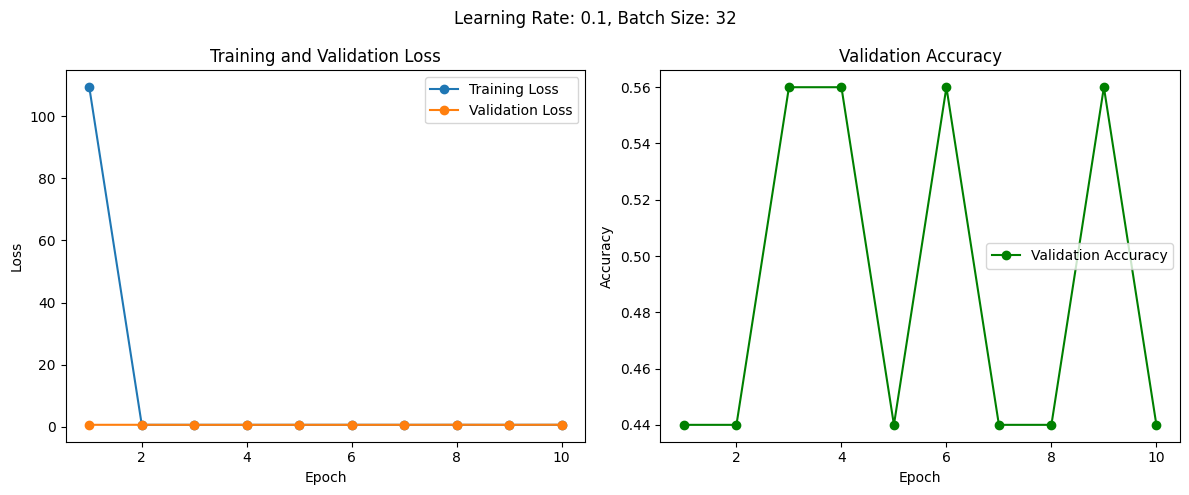

Test Accuracy: 0.4700

Experiment: Learning Rate = 0.1, Batch Size = 64
Epoch 1/10, Validation Loss: 0.7081, Accuracy: 0.5600
Epoch 2/10, Validation Loss: 0.6998, Accuracy: 0.4400
Epoch 3/10, Validation Loss: 0.7010, Accuracy: 0.4400
Epoch 4/10, Validation Loss: 0.6945, Accuracy: 0.4400
Epoch 5/10, Validation Loss: 0.6982, Accuracy: 0.4400
Epoch 6/10, Validation Loss: 0.6937, Accuracy: 0.4400
Epoch 7/10, Validation Loss: 0.6983, Accuracy: 0.4400
Epoch 8/10, Validation Loss: 0.6957, Accuracy: 0.4400
Epoch 9/10, Validation Loss: 0.6984, Accuracy: 0.4400
Epoch 10/10, Validation Loss: 0.6925, Accuracy: 0.5600


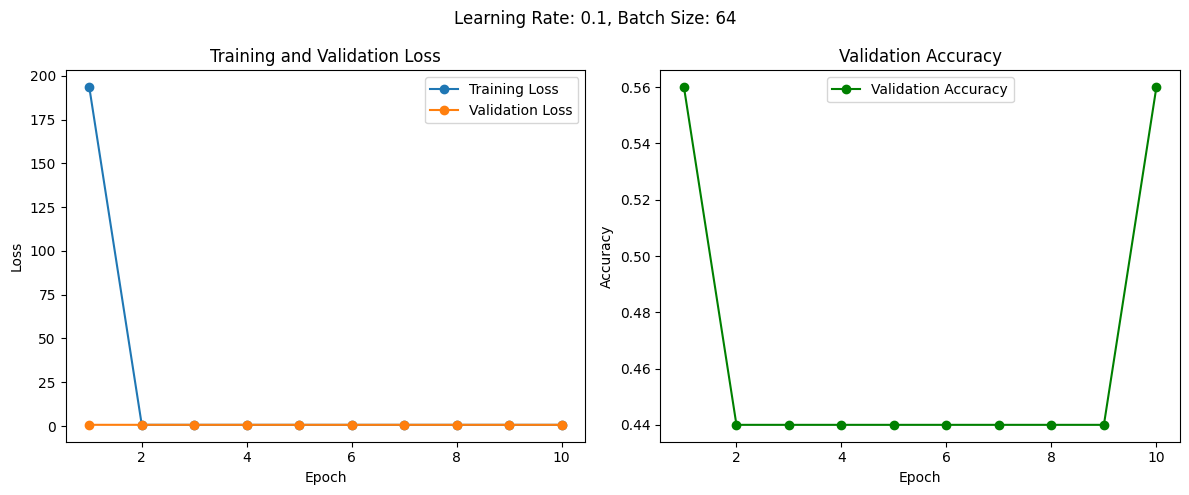

Test Accuracy: 0.5300
Trained model saved at: simple_cnn_model.pth
Predicted class index for image dataset/leopard/0012.jpg: 1


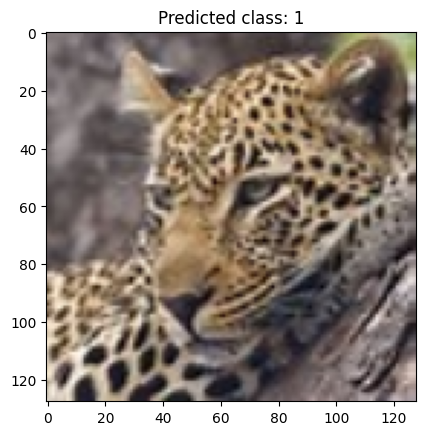

Predicted class index for image dataset/tiger/0004.jpg: 1


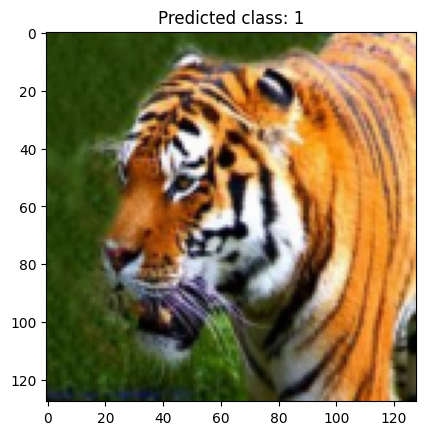

In [11]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    img_train, labels_train, img_val, labels_val, img_test, labels_test = load_dataset(
        "annotation.csv")

    unique_labels = list(set(labels_train + labels_val + labels_test)) 
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    trained_model = main("annotation.csv", num_epochs=10)

    model_save_path = "simple_cnn_model.pth"
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Trained model saved at: {model_save_path}")

    new_model = SimpleCNN(num_classes=len(unique_labels)).to(device)
    new_model.load_state_dict(torch.load(model_save_path))
    new_model.eval()

    img_paths = [
        "dataset/leopard/0012.jpg",
        "dataset/tiger/0004.jpg",
    ]

    for img_path in img_paths:
        img = Image.open(img_path).convert("RGB")

        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        sample_image = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = new_model(sample_image)
            _, predicted_class = torch.max(output, 1)

        print(
            f"Predicted class index for image {img_path}: {predicted_class.item()}")

        img_array = transforms.ToPILImage()(sample_image.squeeze(0).cpu())
        plt.imshow(img_array)
        plt.title(f"Predicted class: {predicted_class.item()}")
        plt.show()